Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
Married
Yes    398
No     213
Name: count, dtype: int64
Self_Employed
No     500
Yes     82
Name: count, dtype: int64


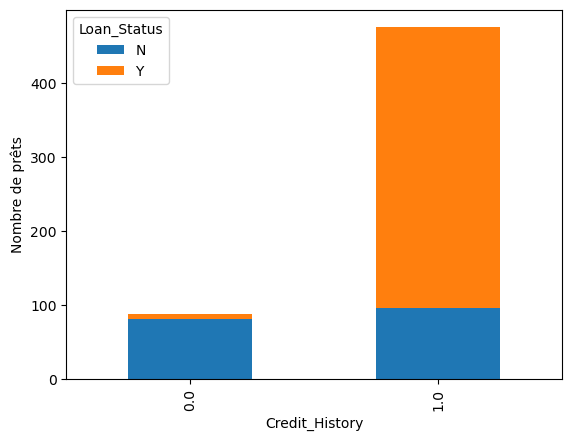

outliers détectés : 
      ApplicantIncome  CoapplicantIncome  LoanAmount
9              12841            10968.0       349.0
126            23803                0.0       370.0
130            20166                0.0       650.0
155            39999                0.0       600.0
171            51763                0.0       700.0
177             5516            11300.0       495.0
183            33846                0.0       260.0
185            39147             4750.0       120.0
278            14583                0.0       436.0
308            20233                0.0       480.0
333            63337                0.0       490.0
369            19730             5266.0       570.0
402             2500            20000.0       103.0
409            81000                0.0       360.0
417             1600            20000.0       239.0
432            12876                0.0       405.0
443            37719                0.0       152.0
487            18333                0.0   

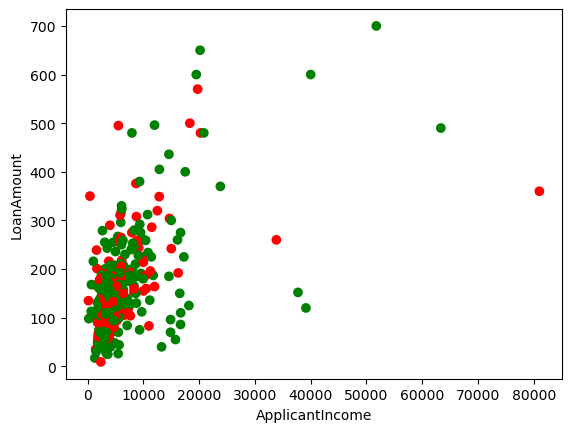

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


C:\Users\Doti-Client\AppData\Local\Temp\ipykernel_4820\1275644400.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = df_scaled.replace({'Married':{'No':0,'Yes':1},'Gender':{'Male':1,'Female':0, 'Unknown':2},'Self_Employed':{'No':0,'Yes':1},
C:\Users\Doti-Client\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


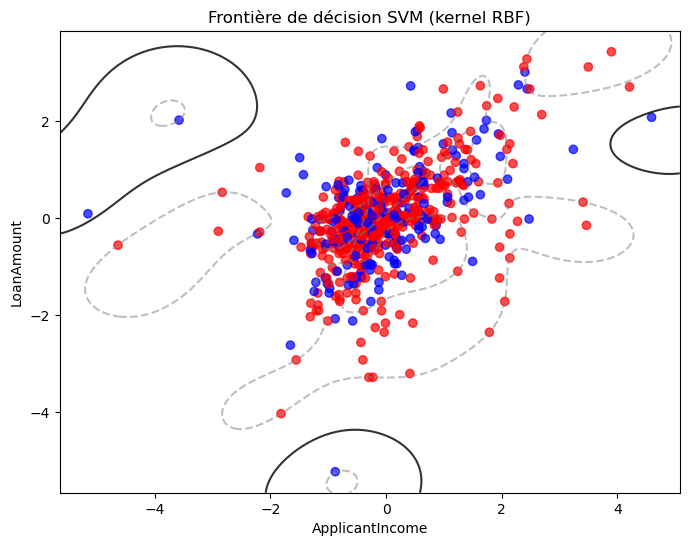

 Accuracy : 0.8048780487804879

 Matrice de confusion :
 [[17 21]
 [ 3 82]]

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.45      0.59        38
           1       0.80      0.96      0.87        85

    accuracy                           0.80       123
   macro avg       0.82      0.71      0.73       123
weighted avg       0.81      0.80      0.78       123

AUC : 0.7513931888544892


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

df = pd.read_csv("loan_status.csv")

#Observations---------------------------------------------------------------------------------------------------------
print(df.isnull().sum())


print(df['Dependents'].value_counts())
print(df['Married'].value_counts())
print(df['Self_Employed'].value_counts())


crosstab = pd.crosstab(df['Credit_History'], df['Loan_Status'])
crosstab.plot(kind="bar", stacked=True)
plt.xlabel("Credit_History")
plt.ylabel("Nombre de prêts")
plt.show()


outliers_df = df[["ApplicantIncome","CoapplicantIncome", "LoanAmount"]]

z_score = (outliers_df - outliers_df.mean()) / outliers_df.std()
outliers = outliers_df[(np.abs(z_score) > 3).any(axis=1)]

print("outliers détectés : \n", outliers)

colors = {'Y' : 'green', 'N': 'red'}
plt.scatter(df["ApplicantIncome"], df["LoanAmount"], c=df["Loan_Status"].map(colors))
plt.xlabel("ApplicantIncome")
plt.ylabel("LoanAmount")
plt.show()

#Nettoyage-----------------------------------------------------------------------------------------------------------------
df.fillna({
    'Gender': 'Unknown',
    'Dependents': 0,
    'Married': 'Yes',
    'Credit_History': 2,
    'Self_Employed': 'No'
}, inplace=True)

df['Loan_Status'] = df['Loan_Status'].fillna('N')
df = df.replace(to_replace='3+', value=4)

df.loc[df['LoanAmount'].isnull(), 'LoanAmount'] = df['LoanAmount'].median()
df.loc[df['Loan_Amount_Term'].isnull(), 'Loan_Amount_Term'] = df['Loan_Amount_Term'].median()
print(df.isnull().sum())

#corriger les outliers
data = df.copy()

df["ApplicantIncome"] = np.log1p(df["ApplicantIncome"])
df["CoapplicantIncome"] = np.log1p(df["CoapplicantIncome"])
df["LoanAmount"] = np.log1p(df["LoanAmount"])

#numérsiation------------------------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler 

df_scaled = df.copy()
cols_to_scale = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
scaler = StandardScaler()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

#encodage
df_encoded = df_scaled.replace({'Married':{'No':0,'Yes':1},'Gender':{'Male':1,'Female':0, 'Unknown':2},'Self_Employed':{'No':0,'Yes':1},
                      'Property_Area':{'Rural':0,'Semiurban':1,'Urban':2},'Education':{'Graduate':1,'Not Graduate':0}})

df_encoded.head()

#training-----------------------------------------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df_encoded.drop(['Loan_ID','Loan_Status'], axis=1)
y = df['Loan_Status'].map({'Y':1, 'N':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808, stratify=y)

svm_model = SVC(kernel='rbf',C=1, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Visualisation de l'hyperplan SVM sur 2 LoanAmount et ApplicantAmount-----------------------------------------------------------------

X_vis = X[['ApplicantIncome', 'LoanAmount']]
y_vis = df['Loan_Status'].map({'Y': 1, 'N': 0})

mask = ~y_vis.isna() & ~X_vis.isna().any(axis=1)
X_vis = X_vis[mask]
y_vis = y_vis[mask]


svm_vis = SVC(kernel='rbf',C=2, gamma='scale')
svm_vis.fit(X_vis, y_vis)

# Nuage de points des deux classes
plt.figure(figsize=(8, 6))
plt.scatter(
    X_vis['ApplicantIncome'],
    X_vis['LoanAmount'],
    c=y_vis,
    cmap='bwr',
    alpha=0.7
)
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')


xlim = plt.xlim()
ylim = plt.ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 200),
    np.linspace(ylim[0], ylim[1], 200)
)

# Prédictions sur la grille
Z = svm_vis.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière et les marges
plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.8, linestyles=['-'])   # frontière
plt.contour(xx, yy, Z, colors='gray', levels=[-1, 1], alpha=0.5, linestyles=['--'])  # marges
plt.title("Frontière de décision SVM (kernel RBF)")
plt.show()



#predictions et tests--------------------------------------------------------------------------------------------------------------

y_pred = svm_model.predict(X_test)

print(" Accuracy :", accuracy_score(y_test, y_pred))
print("\n Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\n Rapport de classification :\n", classification_report(y_test, y_pred))

#calcul de proba d'acceptation 

data['Risk_Score'] = svm_model.predict_proba(X)[:,1]
data['Loan_Status_predict'] = svm_model.predict(X)

#AUC score
from sklearn.metrics import roc_auc_score
print("AUC :", roc_auc_score(y_test, svm_model.predict_proba(X_test)[:,1]))


#Exportation pour analyse power bi
data.to_csv('LoanStatus.csv')

In [2]:
X_train_prediction = svm_model.predict(X_train)
training_data_accuray = accuracy_score(X_train_prediction,y_train)
     

print('Accuracy on training data : ', training_data_accuray)

Accuracy on training data :  0.8187372708757638


In [3]:
X_test_prediction = svm_model.predict(X_test)
test_data_accuray = accuracy_score(X_test_prediction,y_test)
     

print('Accuracy on test data : ', test_data_accuray)

Accuracy on test data :  0.8048780487804879
